In [49]:
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
import random

from sklearn.metrics import silhouette_score

from sklearn.preprocessing import StandardScaler
from itertools import combinations

from collections import Counter

import dill
import shutil

In [50]:
""" Ignore this cell. It is used to carry over results between notebook restarts"""
LOAD_PREV = False

if LOAD_PREV:
    if not os.path.exists('./saved sessions/saved_notebook_session.pkl'):
        print('No saved session found')
        raise ValueError

    with open('./saved sessions/saved_notebook_session.pkl', 'rb') as f:
        dill.load_session(f)
    with open('./saved sessions/saved_notebook_session.pkl', 'wb') as f:
        dill.dump_session(f)

We load the dataset, normalise it to [-1, 1] and flatten it

In [94]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
n_train = x_train.shape[0]
n_test = x_test.shape[0]

# normalise to [-1, 1] so that PCA is not swayed by features with bigger value ranges.
x_train, x_test = x_train/127.5 - 1, x_test/127.5 - 1

# each pixel is a feature. num of pixels = height x width
nb_features = np.prod(x_train.shape[1:])

x_train.resize((n_train, nb_features))
x_test.resize((n_test, nb_features))

### Task 1. Data visualisation (10 points)

In [95]:
# whe can perform PCA since data is already standardised
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train)

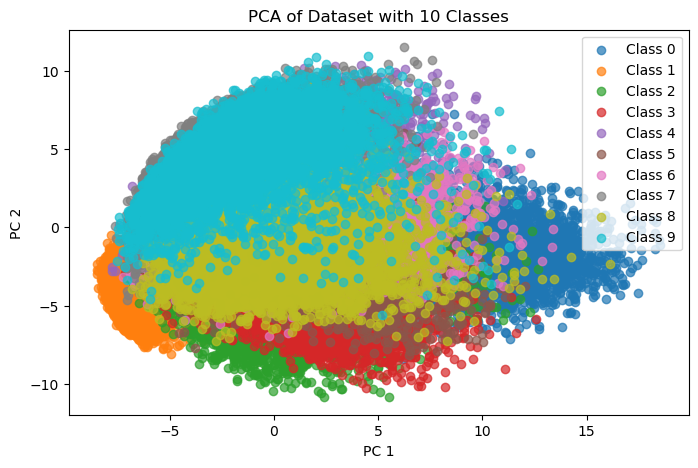

In [96]:
plt.figure(figsize=(8, 5))
# Plot all classes iteratively, on same plot
for digit in range(10):
    plt.scatter(x_train_pca[y_train == digit, 0], x_train_pca[y_train == digit, 1], label=f'Class {digit}', alpha=0.7)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles)) 

plt.legend(by_label.values(), by_label.keys())
plt.title('PCA of Dataset with 10 Classes')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.savefig("./Report LaTeX/plots/plot1.png", dpi=300, bbox_inches='tight')

plt.show()


We get a general idea of the whole dataset but we have to to brake it into smaller part in order to understand it better

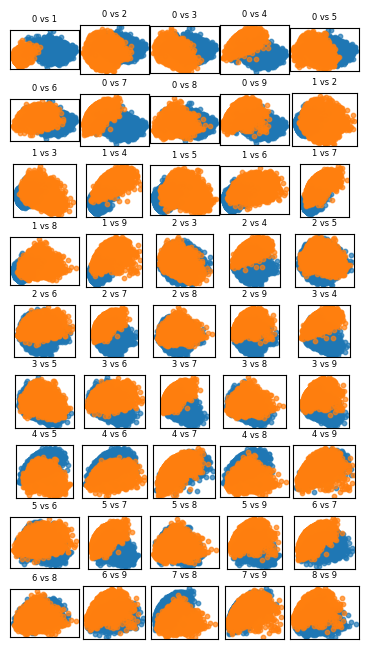

Average silhouette score is: 0.337


In [ ]:
# all pairs of classes
class_pairs = list(combinations(range(10), 2))

# set up plot table shape
fig, axes = plt.subplots(len(class_pairs) // 5 + (len(class_pairs) % 5 != 0), 5, figsize=(4.5, 8))

axes = axes.flatten()

total_sil_score = 0

# for all pairs of digits, take their pca data that we calculated before, plot them and get their silhouette score
for idx, (class1, class2) in enumerate(class_pairs):
    ax = axes[idx]

    cond = (y_train == class1) + (y_train == class2)
    x_train_pca_bin = x_train_pca[cond, :]
    y_train_pca_bin = y_train[cond] * 1

    y_train_pca_bin = np.where(y_train_pca_bin == class1, -1, 1)

    # this calculates the similarity of the cluster's samples which gives a hint to their separability. 
    # Values range from [0 to 1] for datasets with no misclassifications. Higher is better
    sil_score = silhouette_score(x_train_pca_bin, y_train_pca_bin)
    total_sil_score += sil_score
    
    # plot first and second component, for one class and then the other
    ax.scatter(x_train_pca_bin[y_train_pca_bin == -1, 0], x_train_pca_bin[y_train_pca_bin == -1, 1], alpha=0.7, s=10, label=f'Class {class1}')
    ax.scatter(x_train_pca_bin[y_train_pca_bin == 1, 0], x_train_pca_bin[y_train_pca_bin == 1, 1], alpha=0.7, s=10, label=f'Class {class2}')
    
    # Making plot less cluttered
    ax.set_title(f'{class1} vs {class2}', fontsize=6)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

# Remove empty subplots
for idx in range(len(class_pairs), len(axes)):
    fig.delaxes(axes[idx])

# Reuce white space
plt.subplots_adjust(wspace= 0.02, hspace=0.33)

plt.savefig("./Report LaTeX/plots/plot2.png", dpi=300, bbox_inches='tight')
plt.show()

print('Average silhouette score is:', round(total_sil_score/len(class_pairs), 3))

No pair of classes seems easily seperable. We will perform PCA in pairs in order to reduce the noise and influence of other classes.

In [55]:
# function that accepts two digits and returns the corresponding slices of train data and labels
def digit_pairs(x, y, digit1, digit2):
    if digit1 == digit2:
        print('Same digit given twice')
        raise ValueError
    
    cond = (y==digit1) + (y==digit2)
    x_binary = x[cond, :]
    y_binary = y[cond].astype(int)
    y_binary = np.where(y_binary == digit1, -1, 1)

    return x_binary, y_binary

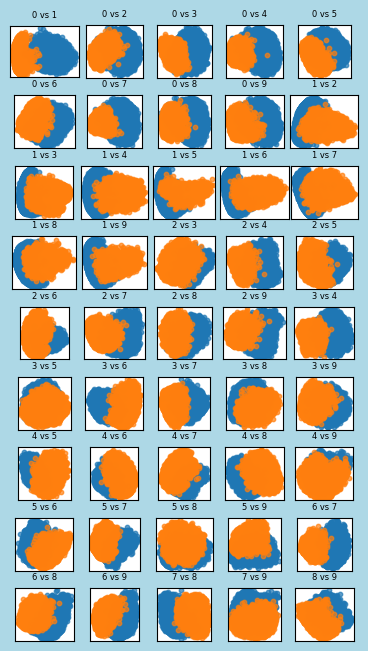

Average silhouette score is: 0.407


In [ ]:
# Same as before, but now PCA is done on each slice of digit pairs, individually
class_pairs = list(combinations(range(10), 2))

fig, axes = plt.subplots(len(class_pairs) // 5 + (len(class_pairs) % 5 != 0), 5, figsize=(4.5, 8))
fig.patch.set_facecolor('lightblue')

axes = axes.flatten()

total_sil_score = 0

pca2 = PCA(n_components=2)
for idx, (class1, class2) in enumerate(class_pairs):
    ax = axes[idx]
    x_train_bin, y_train_bin = digit_pairs(x_train, y_train, class1, class2)
    x_train_bin_pca = pca2.fit_transform(x_train_bin)

    sil_score = silhouette_score(x_train_bin_pca, y_train_bin)
    total_sil_score += sil_score
    
    # Plot
    ax.scatter(x_train_bin_pca[y_train_bin == -1, 0], x_train_bin_pca[y_train_bin == -1, 1], alpha=0.7, s=10, label=f'Class {class1}')
    ax.scatter(x_train_bin_pca[y_train_bin == 1, 0], x_train_bin_pca[y_train_bin == 1, 1], alpha=0.7, s=10, label=f'Class {class2}')
    
    # Making plot less cluttered
    ax.set_title(f'{class1} vs {class2}', fontsize=6)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

# Remove empty subplots
for idx in range(len(class_pairs), len(axes)):
    fig.delaxes(axes[idx])

# Reuce white space
plt.subplots_adjust(wspace= 0.02, hspace=0.33)

plt.savefig("./Report LaTeX/plots/plot3.png", dpi=300, bbox_inches='tight')
plt.show()

print('Average silhouette score is:', round(total_sil_score/len(class_pairs), 3))

We see that the silhouette score has increased, indicating that the samples of each class are better formed than before. Indeed, a visual inspection reveals that most pairs now seem more easily seperable. No pair appears perfectly linearily seperable but a lot (3,4), (3,7), (6, 9) appear more distinct. This concludes Part 1. Next, we will try to train a perceptron to be able to seperate two classes.

### Task 2. Perceptrons (10 points)

Training a perceptron can be broken down into two components: 1) getting the output of the perceptron and 2) using that output to guide the update of its parameters.

The way a perceptron or a neuron works, is that it receives an arbitary number of inputs/stimulations $x = [x_1, x_2, ...]$. These inputs are scaled by a similarily sized weight vector $w^T = [w_1, w_2, ...]$. Thats the perceptron's way of assigning an importance and meaning to each input. Finaly, the sum of the weighted inputs is compared agains a threshold $b$, and a decision is taken based on the result. This serves the puprose if intruducing a non-linearity which mimics the way decisions are often made. (e.g, the higher the temperatuer the more likely it is people will go for a swim, but going for a swim is a binary situation as people generaly do not travel halfway to the swimming pool because the temperature is halfway to heatwave.)


The function `predict(x, w b)` implements these calculations and returns the decision

In [57]:
# calculates dot product of input-x with weights-w and compares to threshold. Returns the result of the comparison which is the final decision.
def predict(x, w, b):
    weighted_sum = np.dot(x, w)
    result = 1 if weighted_sum > b else -1
    return result

This step exposed two kinds of parameters of the perceptron that are not given by the dataset: the weight vector $w$ and the threshold or bias $b$. As these can be set arbitarily, the problem of producing a neuron that pefrorms better than a random chooser can be seen as working out a method that modifies the customisable parameters so that the produce the right output.

One approach for achieving this is as follows:\
a) get one of the training samples and use it to produce a prediction. If the prediction is correct no action needs to be taken. (In the extreme case where all predictions are correct, modifying the parameters can only make the predictor worse)\
b) if the prediction is wrong, the parameters will be changed with two things in mind: 1. The output must change to the direction of the target label. If the target is $1$ and the prediction was $-1$ then the dot product of the input and the weights must increase so that it grows closer to the target, and vice versa. We can get the direction of desired change with $(target - prediction)$. 2. Of all the parameters of the model_deeper_deeper, the ones that are responsible for the mistake must change the most. Naturally, changing the weights of features that are irrelevant to this misclassification will not helpe prevent it in the future, and could undo the work done on these features. We can scale the change to the neurons weights based on their relevance to the misclassification by multiplying with the sample, as by definition, this sample has high values of the features that correspond to the weights that must be changed.
Finaly, a hyperparameter can be used to modify the level of change at each update. Larger values of this learning rate can make initial approach to the local minimum faster but as the distance to it decreases, it can force it to overshoot back and forth above it, preventing improvement. This can be avoided with smaller learning rates at the cost of convergance speed, which must be kept within reasonable times.

These form the core of the training logic. The function `optimise(x, y)` prepares the ground for training the perceptron by first randomly initialising its parameters, while also setting up additional parameters for keeping track of the error and the training iteration. \
The model iterates through all of the samples, producing a prediction and adjusting the weights and bias accordingly.\
A termination condition ensures that the algorithm stops upon reaching a satisfying results, or failing to reach one within the specified time frame.\

In [58]:
# applyis the correction process described above to optimise a given set of parameters w and b
def optimize(x, w, b, y):
    iteration = 0
    mse = np.inf
    # found in practice to work well
    learning_rate = 0.002
    mses = []
    while (iteration <= 1000) & (mse > 1e-3):
        mse, fp, fn = 0, 0, 0
        predictions  = []
        for sample, target in zip(x, y):
            prediction = predict(sample, w, b)
            predictions.append(prediction)
            if prediction != target:
                if prediction > target:
                    fp += 1
                else:
                    fn += 1
                w = w + learning_rate*(target-prediction)*sample
                # the theshold for the dot product is not scaled based on the input, so no *sample
                b = b + learning_rate*(target-prediction)

        iteration += 1
        # average of squared error
        mse = sum((predictions - y)**2)/len(y)
        mses.append(mse)
        accuracy = round(np.sum(predictions == y)/len(y), 4)
        print("Iteration:", iteration, 'with MSE:', round(mse, 4), ', Accuracy:', accuracy, ', False positives:', fp, ', False Negatives:', fn)

    return predictions, w, b, accuracy, mses

# wraps around optimise to provide randomly initialised parameters and the data related to the two digits of interest
def init_and_train(x, y, digit1, digit2):
    x_train_binary, y_train_binary = digit_pairs(x, y, digit1, digit2)
    m, n = x_train_binary.shape
    w = np.random.uniform(-1, 1, n)
    b = np.random.uniform(-1, 1)
    
    return optimize(x_train_binary, w, b, y_train_binary)

preds, weights, bias, accuracy, mses = init_and_train(x_train, y_train, 8, 9)

Iteration: 1 with MSE: 0.2512 , Accuracy: 0.9372 , False positives: 368 , False Negatives: 373
Iteration: 2 with MSE: 0.1454 , Accuracy: 0.9636 , False positives: 215 , False Negatives: 214
Iteration: 3 with MSE: 0.1302 , Accuracy: 0.9675 , False positives: 192 , False Negatives: 192
Iteration: 4 with MSE: 0.1163 , Accuracy: 0.9709 , False positives: 172 , False Negatives: 171
Iteration: 5 with MSE: 0.1075 , Accuracy: 0.9731 , False positives: 158 , False Negatives: 159
Iteration: 6 with MSE: 0.1068 , Accuracy: 0.9733 , False positives: 158 , False Negatives: 157
Iteration: 7 with MSE: 0.1037 , Accuracy: 0.9741 , False positives: 153 , False Negatives: 153
Iteration: 8 with MSE: 0.0983 , Accuracy: 0.9754 , False positives: 145 , False Negatives: 145
Iteration: 9 with MSE: 0.1003 , Accuracy: 0.9749 , False positives: 148 , False Negatives: 148
Iteration: 10 with MSE: 0.0983 , Accuracy: 0.9754 , False positives: 145 , False Negatives: 145
Iteration: 11 with MSE: 0.0902 , Accuracy: 0.9775

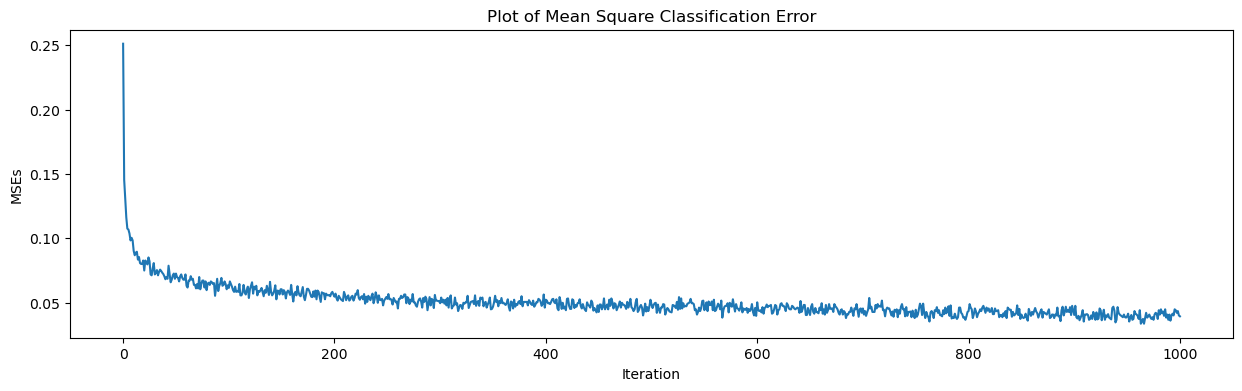

In [59]:
# Plot of MSE vs number of iteration
plt.figure(figsize=(15, 4))
plt.plot(mses)
plt.xlabel('Iteration')
plt.ylabel('MSEs')
plt.title('Plot of Mean Square Classification Error')
plt.show()

In [60]:
# used the model to produce prediction for the test samples, which allows for the test data accuracy to be calculated
def test_data_check(x, y, digit1, digit2, weights, bias):
    x_test_binary, y_test_binary = digit_pairs(x, y, digit1, digit2)
    predictions = []
    for sample in x_test_binary:
        predictions.append(predict(sample, weights, bias))

    accuracy = round(np.sum(predictions == y_test_binary)/len(y_test_binary), 4)
    mse = sum((predictions - y_test_binary)**2)/len(y)
    return accuracy, mse

accuracy, mse = test_data_check(x_test, y_test, 8, 9, weights, bias)
print(accuracy, mse)

0.9692 0.0244


We can edit the optimise function to keep track of the test MSE throughout the training

In [61]:
def optimize(x, w, b, y):
    iteration = 0
    mse = np.inf
    learning_rate = 0.002
    mses = []
    test_mses = []
    while (iteration <= 1000) & (mse > 1e-3):
        mse, fp, fn = 0, 0, 0
        predictions  = []
        for sample, target in zip(x, y):
            prediction = predict(sample, w, b)
            predictions.append(prediction)
            if prediction != target:
                if prediction > target:
                    fp += 1
                else:
                    fn += 1
                w = w + learning_rate*(target-prediction)*sample
                b = b + learning_rate*(target-prediction)

        iteration += 1
        mse = sum((predictions - y)**2)/len(y)
        mses.append(mse)
        # track mse for test dataset as well
        _, test_mse = test_data_check(x_test, y_test, 8, 9, w, b)
        test_mses.append(test_mse)
        accuracy = round(np.sum(predictions == y)/len(y), 4)
        print("Iteration:", iteration, 'with MSE:', round(mse, 4), ', Accuracy:', accuracy, ', False positives:', fp, ', False Negatives:', fn)

    return predictions, w, b, accuracy, mses, test_mses

In [62]:
preds, weights, bias, accuracy, mses, test_mses = init_and_train(x_train, y_train, 8, 9)

Iteration: 1 with MSE: 0.2512 , Accuracy: 0.9372 , False positives: 376 , False Negatives: 365
Iteration: 2 with MSE: 0.1332 , Accuracy: 0.9667 , False positives: 197 , False Negatives: 196
Iteration: 3 with MSE: 0.12 , Accuracy: 0.97 , False positives: 177 , False Negatives: 177
Iteration: 4 with MSE: 0.1098 , Accuracy: 0.9725 , False positives: 162 , False Negatives: 162
Iteration: 5 with MSE: 0.1003 , Accuracy: 0.9749 , False positives: 148 , False Negatives: 148
Iteration: 6 with MSE: 0.0969 , Accuracy: 0.9758 , False positives: 143 , False Negatives: 143
Iteration: 7 with MSE: 0.0922 , Accuracy: 0.9769 , False positives: 136 , False Negatives: 136
Iteration: 8 with MSE: 0.0868 , Accuracy: 0.9783 , False positives: 128 , False Negatives: 128
Iteration: 9 with MSE: 0.0881 , Accuracy: 0.978 , False positives: 130 , False Negatives: 130
Iteration: 10 with MSE: 0.0875 , Accuracy: 0.9781 , False positives: 129 , False Negatives: 129
Iteration: 11 with MSE: 0.0786 , Accuracy: 0.9803 , Fa

In order to evaluate the performance of the classifier we need to know the balance of the classes. Below we plot the class distribution for train and test datasets

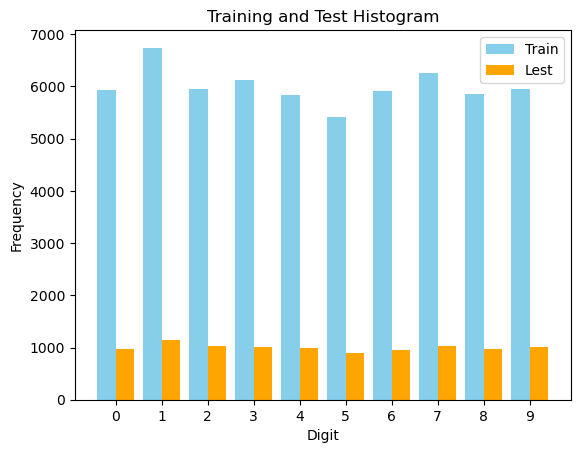

In [63]:
y_train_counts = Counter(y_train)
y_test_counts = Counter(y_test)

axis_points = sorted(set(y_train_counts.keys()).union(y_test_counts.keys()))

frequencies1 = [y_train_counts[item] for item in axis_points]
frequencies2 = [y_test_counts[item] for item in axis_points]

bar_width = 0.4

r1 = [x - bar_width/2 for x in range(len(axis_points))]
r2 = [x + bar_width/2 for x in range(len(axis_points))]

plt.bar(r1, frequencies1, width=bar_width, color='skyblue', label='Train')
plt.bar(r2, frequencies2, width=bar_width, color='orange', label='Lest')
plt.xticks(range(len(axis_points)), axis_points)
plt.xlabel("Digit")
plt.ylabel("Frequency")
plt.title("Training and Test Histogram")
plt.legend()
plt.show()

We see that the classes are close to an equal representation, thus the baseline accuracy and MSE are $10\%$ and $1/10*(2^2)*(10-1) = 3.6$

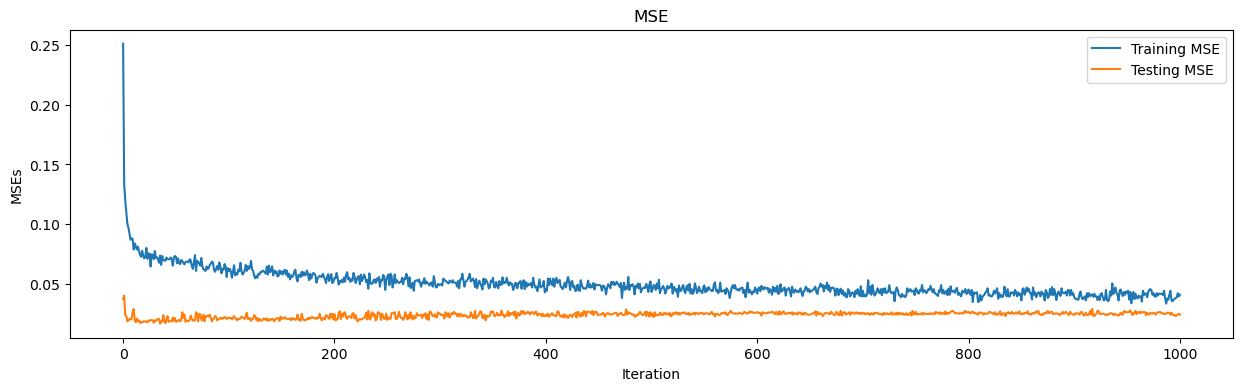

In [ ]:
# Plot of train dataset MSE against test dataset MSE vs number of iteration
plt.figure(figsize=(15, 4))
plt.plot(mses, label='Training MSE')
plt.plot(test_mses, label='Testing MSE')

plt.xlabel('Iteration')
plt.ylabel('MSEs')
plt.title('MSE')
plt.legend()  # Add the legend
plt.savefig("./Report LaTeX/plots/plot5.png", dpi=300, bbox_inches='tight')
plt.show()

We see that while the training MSE keeps decreasing, the test MSE has its minimus at around the 20 iterations point, after which is starts to slowly climp, suggesting overfitting. Given that, training should be stopped at around 20 iterations.

Given that the 2d ndarray `weights` has similar structure with our samples, we can reverse the process that turned them from images to arrays to visualise what our perceptron has learned

In [ ]:
weights_plot = weights.reshape(28, 28)

In [ ]:
def print_digit(sample_no, plot_num):
    digit = sample_no.reshape(28, 28)

    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.savefig(f"./Report LaTeX/plots/plot{plot_num}.png", dpi=300, bbox_inches='tight')
    plt.show()
    

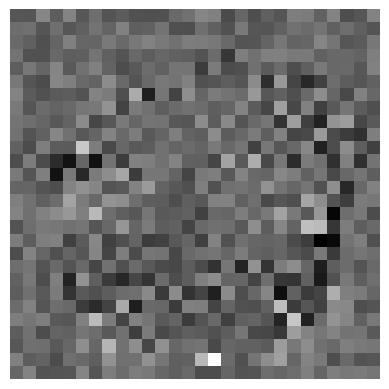

In [ ]:
print_digit(weights_plot, 6)

Here, grey values represent pixes towards which the model has learned to be indifferent (like the edges of the image which usually are not enough to differentiate any digits). With high or low brighness are represented pixels that the model has found sway the prediction towards one of the two classes. While not obvious, we can perhaps see how these pixels are part of the handwriten digit for only one of the classes. \
We can see which pixels would make good features for distinguishing of the two classes by calculating the difference between the pixels that are usually part of the one digit and the ones that are usually part of the other digit, as follows:

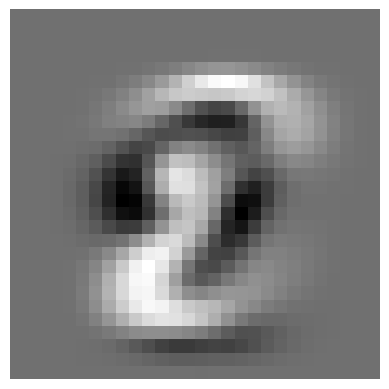

In [68]:
x_8 = x_train[y_train == 8]
x_9 = x_train[y_train == 9]

average_8 = np.mean(x_8, axis=0)
average_9 = np.mean(x_9, axis=0)

dif = average_8 - average_9
print_digit(dif, 7)

There are some similarities, at mid-left mostly, but there does not seem to be too much agreement between the two pictures. This is probably due to the fact that the perceptron learns to use whichever pixels help it classify correctly the samples it failes at, so this could be specific pixels for specific samples, not only the ones that are usefull for the general case. Their weights will get high values, even if they are only usefull rarely. 

In [69]:
random_pairs = [random.sample(range(10), 2) for _ in range(5)]
accuracies = []
for pair in random_pairs:
    preds, weights, bias, accuracy, mses, test_mses = init_and_train(x_train, y_train, pair[0], pair[1])
    accuracies.append(accuracy)


Iteration: 1 with MSE: 0.2404 , Accuracy: 0.9399 , False positives: 353 , False Negatives: 331
Iteration: 2 with MSE: 0.1392 , Accuracy: 0.9652 , False positives: 198 , False Negatives: 198
Iteration: 3 with MSE: 0.123 , Accuracy: 0.9692 , False positives: 175 , False Negatives: 175
Iteration: 4 with MSE: 0.1181 , Accuracy: 0.9705 , False positives: 168 , False Negatives: 168
Iteration: 5 with MSE: 0.1111 , Accuracy: 0.9722 , False positives: 158 , False Negatives: 158
Iteration: 6 with MSE: 0.1033 , Accuracy: 0.9742 , False positives: 147 , False Negatives: 147
Iteration: 7 with MSE: 0.0998 , Accuracy: 0.975 , False positives: 142 , False Negatives: 142
Iteration: 8 with MSE: 0.1044 , Accuracy: 0.9739 , False positives: 148 , False Negatives: 149
Iteration: 9 with MSE: 0.0984 , Accuracy: 0.9754 , False positives: 140 , False Negatives: 140
Iteration: 10 with MSE: 0.0998 , Accuracy: 0.975 , False positives: 142 , False Negatives: 142
Iteration: 11 with MSE: 0.0977 , Accuracy: 0.9756 , 

In [ ]:
df = pd.DataFrame({'Digit Pair':random_pairs, 'Accuracy':accuracies})
df

,Digit Pair,Accuracy
0,"[5, 2]",0.9924
1,"[1, 9]",0.9998
2,"[4, 0]",0.9998
3,"[9, 7]",0.9586
4,"[1, 9]",0.9998


In [ ]:
def dataframe_to_png(df, id):
    fig, ax = plt.subplots(figsize=(4, 2))
    ax.axis('off')
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )
    plt.savefig(f"./Report LaTeX/plots/plot{id}.png", dpi=300, bbox_inches='tight')
    plt.close()

dataframe_to_png(df, 9)

We see that the accuracy scores vary depending on the pair. A visual inspection reveals that pairs with similar overal shape or many similar parts have lower accuracy, for the obvious reasons. We could say that the fewer/shorter lines one needs to draw in order to make one digit look like the other, the lower the accuracy score as noise from the hand drawing can more easily create these lines, leading to a misclassification.

### Task 3. Multi-Layer Perceptron (10 points)

We will now use create a MLP Neural Network with the given architecture specification.

In [71]:
import tensorflow as tf
import os
import datetime

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

mnist = tf.keras.datasets.mnist

In [98]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir "c:/Users/Emmts/OneDrive/Desktop/University of Bath/Phase 3 - Unit 9 - Foundations and Frontiers of Machine Learning/FFoML_GA2/logs"

The model will perform multiclass classification so we will convert the labels from integers to one-hot encoding, paired with the categorical_crossentropy loss function

In [74]:
(x_train, y_train), (X_test, y_test) = mnist.load_data()
x_train = x_train/255
y_train = np.eye(10)[y_train]
X_test = X_test/ 255
y_test = np.eye(10)[y_test]

n_train = x_train.shape[0]
n_test = X_test.shape[0]

# each pixel is a feature. num of pixels = height x width
nb_features = np.prod(x_train.shape[1:])

x_train.resize((n_train, nb_features))
X_test.resize((n_test, nb_features))

In [ ]:
standard_model = Sequential()

# We implement the given specifications
standard_model.add(Dense(1000, input_shape=(X_test.shape[1],), activation='relu'))
standard_model.add(Dense(1000, activation='relu'))
standard_model.add(Dense(10, activation='softmax'))

standard_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# We will use tensorboard to log the results.
log_dir = os.path.join("c:/Users/Emmts/OneDrive/Desktop/University of Bath/Phase 3 - Unit 9 - Foundations and Frontiers of Machine Learning/FFoML_GA2/logs", 'standard')

tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch'
)


base_history = standard_model.fit(x_train, y_train, 
                    epochs=100,
                    batch_size=64,
                    validation_data = (X_test, y_test),     # we do not perform a validation split, instead testing on the test dataset to produce the desired plots
                    callbacks=[tensorboard_callback])

standard_test_loss, standard_test_acc = standard_model.evaluate(X_test, y_test)

# We can calculate the number of params as explained in the report or use the build-in method to directy retrieve it from the model
standard_params = standard_model.count_params()

standard_model.save('./models/standard_mlp')

Epoch 1/100
938/938 [==============================] - 11s 10ms/step - loss: 0.1811 - accuracy: 0.9445 - val_loss: 0.1079 - val_accuracy: 0.9658
Epoch 2/100
938/938 [==============================] - 9s 9ms/step - loss: 0.0743 - accuracy: 0.9770 - val_loss: 0.0776 - val_accuracy: 0.9771
Epoch 3/100
938/938 [==============================] - 9s 10ms/step - loss: 0.0505 - accuracy: 0.9836 - val_loss: 0.0932 - val_accuracy: 0.9745
Epoch 4/100
938/938 [==============================] - 9s 10ms/step - loss: 0.0384 - accuracy: 0.9883 - val_loss: 0.0703 - val_accuracy: 0.9797
Epoch 5/100
938/938 [==============================] - 9s 10ms/step - loss: 0.0318 - accuracy: 0.9899 - val_loss: 0.0813 - val_accuracy: 0.9790
Epoch 6/100
938/938 [==============================] - 10s 11ms/step - loss: 0.0289 - accuracy: 0.9908 - val_loss: 0.0749 - val_accuracy: 0.9791
Epoch 7/100
938/938 [==============================] - 10s 11ms/step - loss: 0.0235 - accuracy: 0.9925 - val_loss: 0.0757 - val_accurac

In [ ]:
results_df = pd.DataFrame({
    'Metric': ['Loss', 'Accuracy'],
    'Value': [round(standard_test_loss, 3), round(standard_test_acc, 3)]
})

dataframe_to_png(results_df, 10)

We notice very good results, owning to the almost 2 million parameters. We will test various architectures to draw conclusions about the relations between number of layer, number of neurons and accuracy

In [76]:
# This function returns a TensorBoard object with parameterised location reflecting different architectures
def tb_callback_setter(subdir):
    log_dir = os.path.join("c:/Users/Emmts/OneDrive/Desktop/University of Bath/Phase 3 - Unit 9 - Foundations and Frontiers of Machine Learning/FFoML_GA2/logs", subdir)

    tensorboard_callback = TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True,
        write_images=True,
        update_freq='epoch'
        )
    
    return tensorboard_callback

In [ ]:
# we repeat the experiment for various depths to investigate how they affect the models characteristics
# we reduce the width of the layers to stay within reasonable training times, also with 1000 the model performs well enough so the added layers have no room for improvement
def create_and_train(num_of_layers, epochs, learning_rate, batch_size):

    model = Sequential()

    model.add(Dense(500, input_shape=(X_test.shape[1],), activation='relu'))

    for _ in range(num_of_layers - 1):
        model.add(Dense(500, activation='relu'))

    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
    
    tensorboard_callback = tb_callback_setter(f'{num_of_layers}_Layers_2')

    history = model.fit(x_train, y_train, 
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data = (X_test, y_test),
                    callbacks=[tensorboard_callback])
    
    test_loss, test_acc = model.evaluate(X_test, y_test)
    params = model.count_params()

    model.save(f'./models/{num_of_layers}_layer_model')

    return model, test_acc, test_loss, params

In [78]:
numbers_of_Layers = [3, 4, 6, 8]
mlp_models = []
mlp_accuracies, mlp_losses, mlp_params = [], [], []

for layers in numbers_of_Layers:
    model, acc, loss, params = create_and_train(layers, 50, 0.001, 64)
    mlp_models.append(model)
    mlp_accuracies.append(acc)
    mlp_losses.append(loss)
    mlp_params.append(params)

Epoch 1/50
938/938 [==============================] - 7s 6ms/step - loss: 0.1975 - accuracy: 0.9408 - val_loss: 0.1234 - val_accuracy: 0.9633
Epoch 2/50
938/938 [==============================] - 6s 7ms/step - loss: 0.0862 - accuracy: 0.9737 - val_loss: 0.0878 - val_accuracy: 0.9727
Epoch 3/50
938/938 [==============================] - 6s 6ms/step - loss: 0.0566 - accuracy: 0.9826 - val_loss: 0.0763 - val_accuracy: 0.9771
Epoch 4/50
938/938 [==============================] - 6s 7ms/step - loss: 0.0459 - accuracy: 0.9854 - val_loss: 0.0849 - val_accuracy: 0.9750
Epoch 5/50
494/938 [==============>...............] - ETA: 2s - loss: 0.0340 - accuracy: 0.9890

KeyboardInterrupt: 

We can combine the values for parameters and accuracy of all our 5 models to see who the two relate

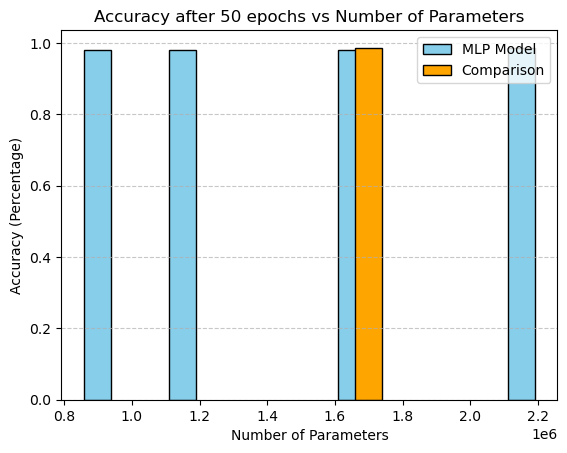

In [ ]:
plt.bar(mlp_params, mlp_accuracies, color='skyblue', edgecolor='black', width=80000, label='MLP Model')

plt.bar(
    base_params,
    base_test_acc,
    color='orange',
    edgecolor='black',
    width=80000,
    label='Comparison'
)

plt.title("Accuracy at 50 epochs vs Number of Parameters")
plt.xlabel("Number of Parameters")
plt.ylabel("Accuracy (Percentage)")

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Task 4. Convolutional Neural Networks (10 points)

In [58]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [63]:
(x_train, y_train), (X_test, y_test) = mnist.load_data()
x_train = x_train/255
y_train = np.eye(10)[y_train]
X_test = X_test/ 255
y_test = np.eye(10)[y_test]

In [64]:
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [66]:
model = models.Sequential()

model.add(layers.Conv2D(32, (4, 4), strides=1, activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Conv2D(64, (4, 4), strides=2, activation='relu'))
model.add(layers.Conv2D(128, (4, 4), strides=2, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=10,
    validation_data=(x_test, y_test)
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 25, 25, 32)        544       
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        32832     
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         131200    
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_54 (Dense)            (None, 10)                20490     
                                                                 
Total params: 185,066
Trainable params: 185,066
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
938/938 [===========================

## End

In [97]:
with open('./saved sessions/saved_notebook_session.pkl', 'wb') as f:
    dill.dump_session(f)

INFO:tensorflow:Assets written to: ram://5c9514a9-9394-4758-875b-fb4c6dc2278e/assets


InvalidArgumentError: Cannot convert a Tensor of dtype resource to a NumPy array.